In [2]:
import pandas as pd


In [18]:
control_url = 'https://raw.githubusercontent.com/sayakpaul/A-B-testing-with-Machine-Learning/master/data/control_data.csv'
control = pd.read_csv(control_url, parse_dates=[0])

experiment_url = 'https://raw.githubusercontent.com/sayakpaul/A-B-testing-with-Machine-Learning/master/data/experiment_data.csv'
experiment = pd.read_csv(experiment_url, parse_dates=[0])

In [19]:
experiment.head(2)

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0


In [20]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [21]:
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [22]:
control.isna().sum()


Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [23]:
experiment.isna().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [24]:
control[control['Enrollments'].isna()]


,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9437,788,NaN,NaN
24,"Tue, Nov 4",9420,781,NaN,NaN
25,"Wed, Nov 5",9570,805,NaN,NaN
26,"Thu, Nov 6",9921,830,NaN,NaN
27,"Fri, Nov 7",9424,781,NaN,NaN
28,"Sat, Nov 8",9010,756,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN
30,"Mon, Nov 10",10419,874,NaN,NaN
31,"Tue, Nov 11",9880,830,NaN,NaN
32,"Wed, Nov 12",10134,801,NaN,NaN


In [25]:
# Combine with Experiment data
data_total = pd.concat([control, experiment])
data_total.sample(10)


,Date,Pageviews,Clicks,Enrollments,Payments
18,"Wed, Oct 29",9262,727,201.0,96.0
6,"Fri, Oct 17",9008,748,146.0,76.0
31,"Tue, Nov 11",9931,831,NaN,NaN
8,"Sun, Oct 19",8459,691,131.0,60.0
13,"Fri, Oct 24",9434,673,220.0,122.0
3,"Tue, Oct 14",9867,827,138.0,92.0
20,"Fri, Oct 31",8890,706,174.0,101.0
22,"Sun, Nov 2",8836,724,182.0,103.0
24,"Tue, Nov 4",9420,781,NaN,NaN
19,"Thu, Oct 30",9308,728,207.0,67.0


In [26]:
import numpy as np
np.random.seed(7)
import sklearn.utils

# Add row id
data_total['row_id'] = data_total.index

# Create a Day of Week feature
data_total['DOW'] = data_total['Date'].str.slice(start=0, stop=3)

# Remove missing data
data_total.dropna(inplace=True)

# Add a binary column Experiment to denote
# if the data was part of the experiment or not (Random)
data_total['Experiment'] = np.random.randint(2, size=len(data_total))

# Remove missing data
data_total.dropna(inplace=True)

# Remove Date and Payments columns
del data_total['Date'], data_total['Payments']

# Shuffle the data
data_total = sklearn.utils.shuffle(data_total)


In [27]:
data_total.head(2)

,Pageviews,Clicks,Enrollments,row_id,DOW,Experiment
21,8460,681,156.0,21,Sat,0
3,9867,827,138.0,3,Tue,1


In [28]:
# Reorder the columns 
data_total = data_total[['row_id', 'Experiment', 'Pageviews', 'Clicks', 'DOW', 'Enrollments']]


In [29]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_total.loc[:, data_total.columns != 'Enrollments'],\
                                                    data_total['Enrollments'], test_size=0.2)


In [30]:
# Converting strings to numbers
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
X_train['DOW'] = lb.fit_transform(X_train['DOW'])
X_test['DOW'] = lb.transform(X_test['DOW'])


In [32]:
X_train.head()
X_test.head()

,row_id,Experiment,Pageviews,Clicks,DOW
12,12,0,8324,665,4
18,18,1,9262,727,6
1,1,0,9288,785,3
1,1,0,9102,779,3
19,19,0,9345,734,4


In [33]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))


In [34]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()


In [35]:
import statsmodels.api as sm

X_train_refined = X_train.drop(columns=['row_id'], axis=1)
linear_regression = sm.OLS(y_train, X_train_refined)
linear_regression = linear_regression.fit()


In [36]:
X_test_refined = X_test.drop(columns=['row_id'], axis=1)
y_preds = linear_regression.predict(X_test_refined)


In [37]:
calculate_metrics(y_test, y_preds)


RMSE Score: 23.988871314039862
R2_Squared: 0.050950018270392916
MAE Score: 19.586061838775095


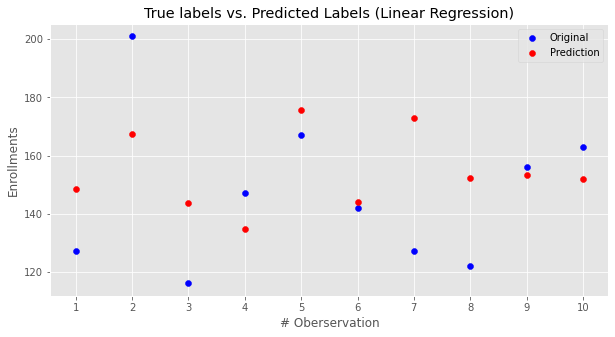

In [38]:
plot_preds(y_test, y_preds, 'Linear Regression')


In [39]:
print(linear_regression.summary())


                                 OLS Regression Results                                
Dep. Variable:            Enrollments   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              400.1
Date:                Wed, 10 Mar 2021   Prob (F-statistic):                    7.92e-27
Time:                        20:59:59   Log-Likelihood:                         -163.65
No. Observations:                  36   AIC:                                      335.3
Df Residuals:                      32   BIC:                                      341.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [40]:
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')


,Terms,p_value
1,Pageviews,1.974764e-07
2,Clicks,3.804647e-05
3,DOW,2.299762e-01
0,Experiment,8.634578e-01


In [41]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)


RMSE Score: 26.8540034259326
R2_Squared: -0.1892893660531696
MAE Score: 21.78333333333333


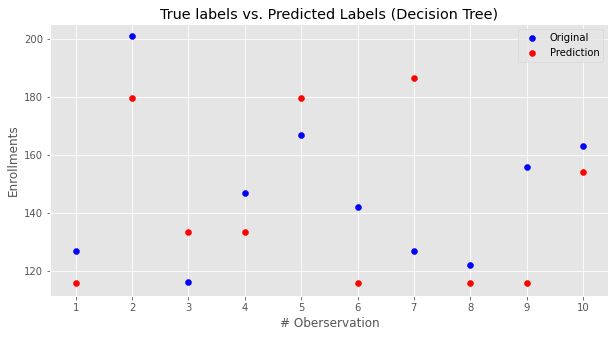

In [42]:
plot_preds(y_test, y_preds, 'Decision Tree')


In [57]:
import xgboost as xgb


In [58]:
DM_train = xgb.DMatrix(data=X_train_refined,label=y_train)
DM_test = xgb.DMatrix(data=X_test_refined,label=y_test)


In [60]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}


In [61]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

calculate_metrics(y_test, y_preds)


[21:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth, n_estimators, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE Score: 20.665871161912893
R2_Squared: 0.2956688586305446
MAE Score: 19.405903625488282


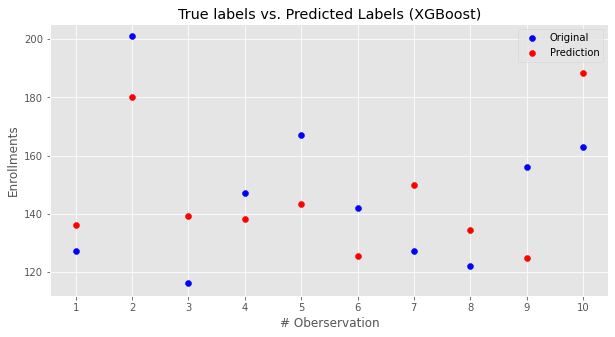

In [62]:
plot_preds(y_test, y_preds, 'XGBoost')


In [63]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 mins 22 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_fiv24242_q1y1uy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.204 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [53]:
X_train['Enrollments'] = y_train
X_test['Enrollments'] = y_test


In [54]:
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
features = X_train.columns.values.tolist()
target = "Enrollments"


In [ ]:
# Overview of how the models performed
#auto_h2o.leaderboard


In [ ]:
# Extract the best model from the leaderboard
#auto_h2o = auto_h2o.leader


In [ ]:
#X_test_temp = X_test.copy()
#del X_test_temp['Enrollments']


In [ ]:
# Employing the model to make inference
#X_test_h2o_copy = h2o.H2OFrame(X_test_temp)
#y_preds = auto_h2o.predict(X_test_h2o_copy)

# Convert the predictions to a native list
#y_preds = h2o.as_list(y_preds["predict"])


In [ ]:
#calculate_metrics(y_test, y_preds)


In [52]:
#explanations will be added soon

#ref
#https://www.business-science.io/business/2019/03/11/ab-testing-machine-learning.html
